# Inaugural Project - Housing demand and taxation
### Introduction to Programming and Numerical Analysis

**University of Copenhagen, 21 March 2021**

Hand-in by Magnus Bugge, Jens Brøndum Petersen, and Frederik Bach

# Housing demand and taxation

We consider a household looking to buy a home. The household is endowed with an amount of cash-on-hand, $m$, that may spent on housing as well as other consumption $c$. The household derives utility from housing by a measure of its quality, $h$. A home of quality $h$ has the price $ph$ and is subject to progressive taxation and mortgage costs, summarized by the function $\tau(\cdot)$. The objective of the household is therefore to choose optimal amounts of housing and consumption.

# Problem 1 - Household utility maximization 

The representative household's problem is given by:

$$c^*, h^* = \arg \underset{c,h}{\max} c^{1-\phi}h^\phi \\
                s.t. \\
    \tilde{p}_h = p_h\varepsilon \\
              m = \tau(p_h,\tilde{p}_h)+c \\
\tau(p_h,\tilde{p}_h = rp_h+\tau^h\tilde{p}_h+\tau^p\max\{\tilde{p}_h-\bar{p},0\}$$ 

We take as given the default parameters: 
$\phi = 0.3, \varepsilon = 0.5, r = 0.03, \tau^g = 0.012, \tau^g = 0.004, 
\bar{p} = 3$

The parameters are defined in the dictionary 'parameters' in the code section below.

In [2]:
# import numpy for array operations and the scipy optimize module for optimization
import numpy as np
from scipy import optimize

# create a dictionary containing the parameters given
parameters = {'phi': 0.3, 'eps': 0.5, 'r': 0.03, 'tau_g': 0.012, 
              'tau_p': 0.004, 'p_bar': 3, 'm': 0.5}

Now, we construct the utility function along with the maximization constraints as individual functions:

In [3]:
def utility_function(c, h, parameters):
    """ Defines utility function based on consumption bundle and parameters        
    
    Args:
        c (float): amount of consumption in non-housing goods 
        h (float): housing consumption
        parameters (dict): dictionary of parameters wrt. policy and preferences
        
    Returns:
        u (float): utility        
    """

    u = c**(1-parameters['phi']) * h**parameters['phi']
    return u


def taxes_paid(h, parameters):
    """ Calculates the cash amount of taxes paid by the individual household given the choice of house quality      
    
    Args:
        h (float): housing consumption
        parameters (dict): dictionary of parameters wrt. policy and preferences
        
    Returns:
        taxes (float): cash amount of taxes paid
    """
    
    taxes = parameters['r'] * h + parameters['tau_g'] * h * parameters['eps'] + parameters['tau_p'] * max(h * parameters['eps'] - parameters['p_bar'], 0)
    return taxes
    
    
def budget_constraint(h, parameters):
    """ Defines the budget constraint of the household, which says that consumption is equal to the cash-on-hand minus tax expenditure   
    
    Args:
        h (float): housing consumption
        parameters (dict): dictionary of parameters wrt. policy and preferences
        
    Returns:
        c (float): the upper limit (budget constraint) for consumption in non-housing goods
    """ 
    
    c = parameters['m'] - taxes_paid(h, parameters)
    return c

Now, we define the objective function and maximize it wrt. c and h

In [4]:
# objective function (we maximize it by minimizing the negative utility function)
def value_of_choice(h, parameters):
    """ Defines the objective function to be optimized
    
    Args:
        h (float): housing consumption
        parameters (dict): dictionary of parameters wrt. policy and preferences
        
    Returns:
        -utility_function (float): the negative of the implied utility from consumption c and h
    """ 

    c = budget_constraint(h, parameters)
    return -utility_function(c, h, parameters)


# use the optimizer from the scipy package to optimize value_of_choice
def solver(parameters):
    """ Solves the household's utility maximization problem given the parameters
    Args:
        parameters (dict): dictionary of parameters wrt. policy and preferences
        
    Returns:
        -h (float): optimal choice of housing
    """ 
    solution = optimize.minimize_scalar(
    value_of_choice, bounds = None, args = (parameters))
    h = solution.x
    return h

# save the optimal consumption bundle and the implied utility the variables h, c, and u
h = solver(parameters)
c = budget_constraint(h, parameters)
u = utility_function(c, h, parameters)

# print the solution
print(h)
print(c)
print(u)

4.1666666039527485
0.35000000225770106
0.7358414678061572


# Problem 2 - Plot of c* and h* as functions of m in the range 0.4 to 1.5

In [5]:
# import the pandas package for dataframe
import pandas as pd

# define a range of endowments, m, to be iterated over
m_range = np.arange(0.4, 1.5, 0.01).tolist()

# initialize an empty array
solutions = []

# use the optimization algorithm from problem 1 for all m's in m_range
for m in m_range:
    parameters['m'] = m
    h = solver(parameters)
    c = budget_constraint(h, parameters)
    solutions.append([m, h, c])

# save the solutions in a pandas dataframe and print it
solutions = pd.DataFrame(solutions, columns=["m", "h", "c"])
print(solutions)

        m          h       c
0    0.40   3.333333  0.2800
1    0.41   3.416667  0.2870
2    0.42   3.500000  0.2940
3    0.43   3.583333  0.3010
4    0.44   3.666667  0.3080
..    ...        ...     ...
105  1.45  11.542105  1.0234
106  1.46  11.621053  1.0304
107  1.47  11.700000  1.0374
108  1.48  11.778948  1.0444
109  1.49  11.857895  1.0514

[110 rows x 3 columns]


Now, after obtaining a dataframe of 110 solutions to the household's problem, we plot it using the matplotlib package

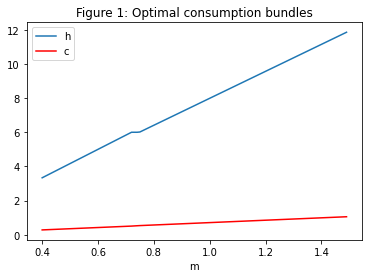

In [6]:
# import the matplotlib pyplot module package for the plot
import matplotlib.pyplot as plt

# plot the solution dataframe
m_axis = plt.gca()
solutions.plot(x = 'm', y = 'h', ax = m_axis, title = 'Figure 1: Optimal consumption bundles');
solutions.plot(x = 'm', y = 'c', ax = m_axis, color = 'red');

From figure 1, we see that the consumption bundle is increasing in both goods for increasing endowments, which is a result of the monotonous utility function.

What is interesting here is that around the endowment m = 0.72, the households begin buying houses that are taxed in the higher tax bracket. Initially,

this causes the households to being reluctant on buying more expensive houses, since the marginal utility on consumption is higher. However, when the 

endowment reaches a certain point, the households again begin buying more and more expensive houses.

# Problem 3 - Average tax burden

Here, we calculate the average tax burden among 10,000 households assuming that cash endowments follow a log-normal distribution.

In [7]:
# set the number of households and the seed number
N = 10000
seed = 1

# draw list of 10,000 cash endowments from the lognormal distributions
from statistics import mean
np.random.seed(seed)
m_sim = np.random.lognormal(mean = -0.4,sigma = 0.35,size = N).tolist()

def tax_burden(h, parameters):
    '''calculate the individual tax burden given the choice of housing'''
    return parameters['tau_g'] * h * parameters['eps'] + parameters['tau_p'] * max(h * parameters['eps'] - parameters['p_bar'], 0)

# calculate the average tax burden
household_tax = []
for m in m_sim:
    parameters['m'] = m
    h = solver(parameters)
    household_tax.append(tax_burden(h, parameters)) 

avg_tax_burden = mean(household_tax)
print(avg_tax_burden)

0.03632680342490658


Now, we plot the distributions of h and c given the simulations of the cash endowment.

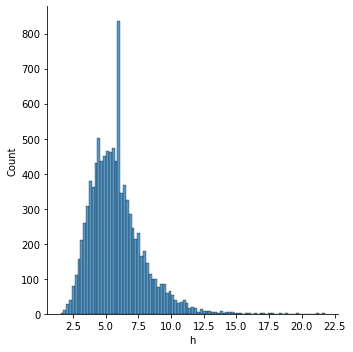

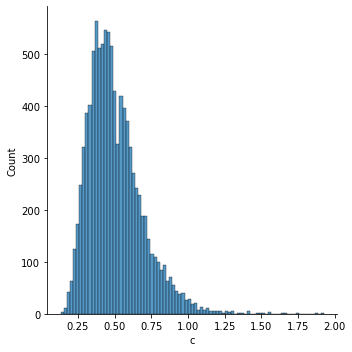

In [8]:
# Plot of distributions
import seaborn as sns

solutions = []

for m in m_sim:
    parameters['m'] = m
    h = solver(parameters)
    c = budget_constraint(h, parameters)
    solutions.append([m, h, c])

solutions = pd.DataFrame(solutions, columns=["m", "h", "c"])

sns.displot(solutions, x="h")
sns.displot(solutions, x="c")

What is interesting from the plots above is the skewness of the distributions. This seems to be due to the tax schedule which has two tax brackets. That is, households 

are taxes differently depending on the public assessment of their house. As we also saw in problem 2, households stop buying more expensive houses when reaching the

endowment region of rougly m = 0.72. Therefore, there is an outlier of households who buy houses of the approximate value of h = 6.

# Problem 4 - Tax reform

Now, the government imposes a tax reform which alternates some of the given parameters. We implement the new parameters by creating a new dictionary.

In [10]:
# Create a dictionary containing the new parameters
parameters_reform = {'phi': 0.3, 'eps': 0.8, 'r': 0.03, 'tau_g': 0.01, 
              'tau_p': 0.009, 'p_bar': 8, 'm': 0.5}

household_tax_reform = []
for m in m_sim:
    parameters_reform['m'] = m
    h = solver(parameters_reform)
    household_tax_reform.append(tax_burden(h, parameters_reform)) 

avg_tax_burden_reform = mean(household_tax_reform)
print(avg_tax_burden_reform)

0.045036293136158256


We see from t_reform that the average tax burden has increased from 0.036 to 0.045.

# Problem 5 - re-engineering the tax reform

Now, the government wants to re-engineer the tax reform, such that the average tax burden is unchanged between the tax schedules. They want to do this by imposing the new parameters, while lowering $\tau_g$, so the tax effects are offset. 

In [23]:
parameters_reform_new = {'phi': 0.3, 'eps': 0.8, 'r': 0.03, 'tau_g': 0.01, 
              'tau_p': 0.009, 'p_bar': 8, 'm': 0.5}

tau_g_iter = np.arange(0, 0.019, 0.00001).tolist()

# set the number of households and the seed number
N_new = 10

# draw list of 10 cash endowments from the lognormal distribution
m_sim_new = np.random.lognormal(mean = -0.4,sigma = 0.35,size = N_new).tolist()

while avg_tax_burden_reform < avg_tax_burden:
    for tau_g in tau_g_iter:
        parameters_reform_new['tau_g'] = tau_g
        household_tax_reform = []

        for m in m_sim_new:
            parameters_reform_new['m'] = m
            h = solver(parameters_reform_new)
            household_tax_reform.append(tax_burden(h, parameters_reform_new))
    
        avg_tax_burden_reform = mean(household_tax_reform)
        if(avg_tax_burden_reform >= avg_tax_burden):
            break

print(f'With tau_g = {tau_g:4f}, the tax burden is {avg_tax_burden_reform:4f}.')

With tau_g = 0.007830, the tax burden is 0.036333.


Thus, for $\tau_g=0.0078$, the government obtains an unchanged average tax burden under the new tax schedule.